<a href="https://www.kaggle.com/code/hwanchul/lending-club-prep?scriptVersionId=262332596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 데이터 불러오기

In [3]:
import kagglehub
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df1 = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv', low_memory=False)
#df2 = pd.read_csv('/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv', low_memory=False)

print("--- df1's info ---")
df1.info()

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv
--- df1's info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## 프로젝트 목표 
___
- 대출자의 부도 예측: 대출 상환에 실패할 (Default) 대출자를 사전에 예측하는 분류(Classification) 문제.

- 타겟 변수 정의
    - loan_status를 활용하여 label 변수 생성
    
        - 부도(Default) 그룹: Charged Off, Default, Late (31-120 days)
    
        - 정상(Non-Default) 그룹: Fully Paid, Current
    
        - In Grace Period는 아직 부도로 확정되지 않은 상태이므로, 분석 목적에 따라 정상 그룹에 포함하거나 제외할 수 있습니다.

## 컬럼별 정보

### accepted_2007_to_2018Q4
___
대출이 승인된 기록과 대출 상환에 대한 정보

- id / member_id: 대출의 고유 식별자입니다.

- loan_amnt: 신청된 대출 금액입니다.

- funded_amnt: 승인된 대출 금액입니다.

- funded_amnt_inv: 투자자들에게 실제 자금이 조달된 금액입니다.

- term: 대출 상환 기간 (예: 36개월, 60개월)입니다.

- int_rate: 대출 금리(이자율)입니다.

- installment: 매월 상환해야 하는 원리금(원금 + 이자)입니다.

- grade / sub_grade: Lending Club이 자체적으로 평가한 신용 등급입니다. (예: A, B, C / A1, A2...)

- emp_title: 대출 신청자의 직업입니다.

- emp_length: 현재 직장에서의 근무 기간입니다.

- home_ownership: 대출 신청자의 주거 형태입니다. (예: 임대, 자가 소유, 모기지)

- annual_inc: 연간 소득입니다.

- verification_status: 소득 정보의 인증 여부입니다.

- issue_d: 대출이 승인된 날짜입니다.

- loan_status: 가장 중요한 컬럼 중 하나로, 대출의 현재 상태를 나타냅니다. (예: Fully Paid - 전액 상환, Charged Off - 부도 처리)

- purpose: 대출 목적입니다. (예: 신용카드 부채 통합, 주택 개조, 사업 자금)

- title: 대출자가 직접 기입한 대출 제목입니다.

- addr_state: 대출 신청자의 주(State)입니다.

- dti: 부채-소득 비율(Debt-to-Income Ratio)입니다. 월간 부채 상환액이 월 소득에서 차지하는 비율을 나타냅니다.

- delinq_2yrs: 지난 2년간 30일 이상 연체된 횟수입니다.

- pub_rec: 공공 기록에 남은 연체(부도) 횟수입니다.

- revol_bal: 회전식 신용 잔고(Revolving balance)입니다. 신용카드를 사용하고 갚지 않은 잔액을 의미합니다.

- total_acc: 총 신용 계좌(신용카드, 대출)의 개수입니다.

- earliest_cr_line: 신용 거래 시작일입니다.

- mort_acc: 모기지 계좌의 개수입니다.

- pub_rec_bankruptcies: 공공 기록에 남은 파산 횟수입니다.

- tax_liens: 세금 유치권(체납) 개수입니다.

- tot_cur_bal: 모든 계좌의 총 현재 잔액입니다.

### rejected_2007_to_2018Q4
___

대출이 거절된 기록

- Amount Requested: 신청된 대출 금액입니다.

- Application Date: 대출 신청일입니다.

- Loan Title: 대출 목적입니다.

- Risk_Score: Lending Club이 산정한 자체 리스크 점수입니다. 점수가 높을수록 리스크가 낮습니다.

- Debt-To-Income Ratio: 부채-소득 비율입니다.

- State: 신청자의 주(State)입니다.

- Employment Length: 현재 직장에서의 근무 기간입니다.

- Policy Code: 대출 정책 코드입니다.

# 분석데이터 만들기

## 데이터 필터링
___

In [4]:
# 대출승인날짜(issue_d)를 토대로 대출승인 년도(issue_year), 월(issue_month), 분기(issue_quarter) 정보 추출

df1.dropna(subset=['issue_d'], inplace=True) ## issue_d 결측 데이터 삭제 --> 33개

df1['issue_month'] = df1['issue_d'].str.split('-', expand=True)[0]
df1['issue_year'] = df1['issue_d'].str.split('-', expand=True)[1].astype(int)

def get_quarter(month):
    if month in ['Jan', 'Feb', 'Mar']:
        return 'Q1'
    elif month in ['Apr', 'May', 'Jun']:
        return 'Q2'
    elif month in ['Jul', 'Aug', 'Sep']:
        return 'Q3'
    else:
        return 'Q4'

df1['issue_quarter'] = df1['issue_month'].apply(get_quarter)

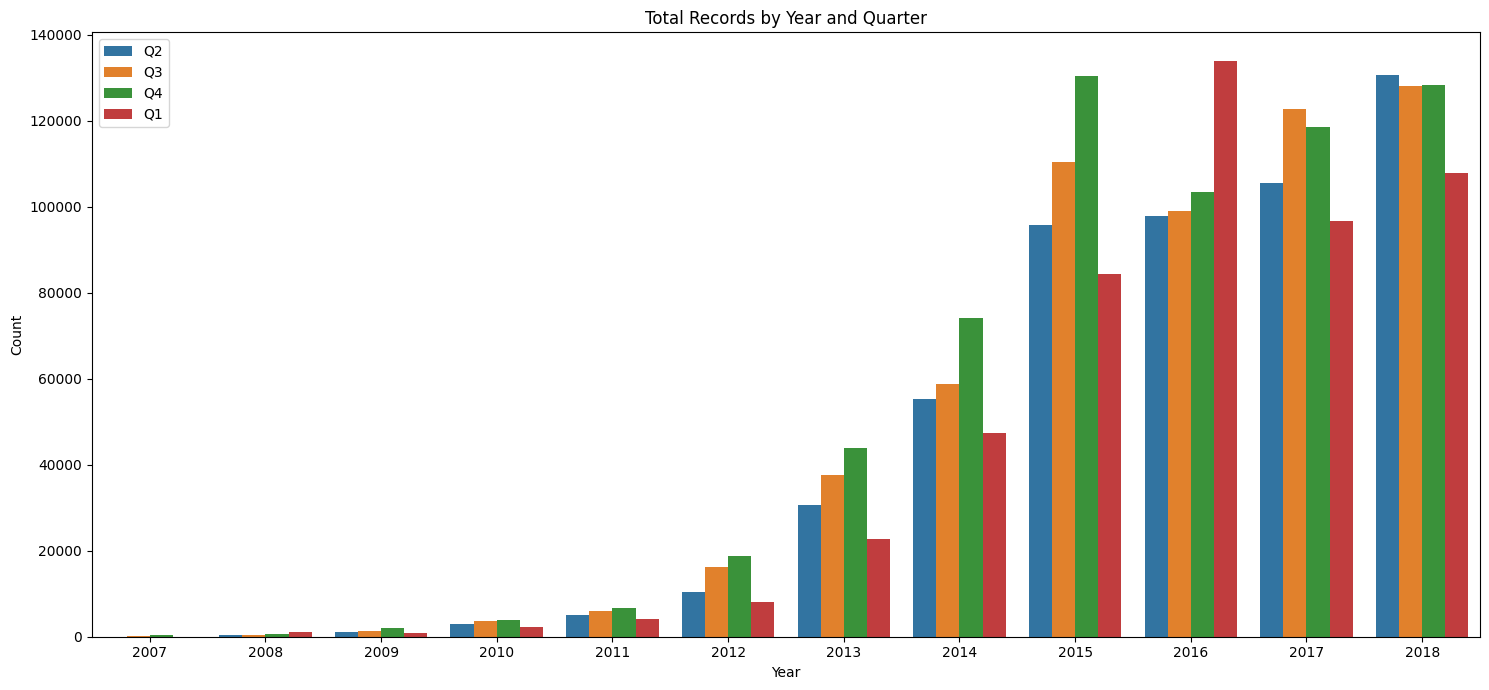

In [5]:
# 연도별 총 레코드 수 계산
total_records_by_year = df1['issue_year'].value_counts().sort_index()

# 연도-분기별 총 레코드 수
total_records_by_quater = df1.groupby(['issue_year', 'issue_quarter'])['issue_d'].count().sort_index()
total_records_by_quater.name = 'count'

# 연도-분기별 총 레코드 수 시각화
plt.figure(figsize=(15, 7))

sns.barplot(x='issue_year', y='count', hue='issue_quarter', data=total_records_by_quater.reset_index())
plt.title('Total Records by Year and Quarter')
plt.xlabel('Year'); plt.ylabel('Count')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

데이터 필터링 기준 및 이유
___
분석데이터를 `2015`년 이후 데이터만 활용 후 추후 확장 고려

In [6]:
df1 = df1[df1['issue_year'] == 2015]

## 타겟 변수 정의
___

대출 상태(loan_status) 값별 의미
___
NonDefault Group
- Fully Paid: 대출자가 모든 원금과 이자를 전액 상환하여 대출 계약이 완료된 상태입니다. 이는 대출 상환에 성공한 사례로 분류됩니다.

- Current: 대출자가 현재 상환 기한을 잘 지키고 있는 상태입니다. 이 대출들은 아직 계약이 끝나지 않았으며, 현재로서는 부도 위험이 없는 것으로 간주됩니다.

Default Group
- Charged Off: 대출 상환이 불가능하다고 판단되어 부도 처리된 상태입니다. 이는 회수 가능성이 낮아 손실로 기록된 경우입니다. 모델링에서는 주로 이 값을 '부도(Default)'로 정의합니다.

- Late (31-120 days): 대출 상환일로부터 31일에서 120일 사이로 연체된 상태입니다.

- Late (16-30 days): 상환일로부터 16일에서 30일 사이로 연체된 상태입니다.

- Default: 대출 상환 의무를 이행하지 못해 부도 상태에 빠진 경우입니다. Charged Off와 유사하지만, Lending Club의 내부 정책에 따라 부도 처리 전 단계로 분류될 수 있습니다.

Else
- In Grace Period: 상환일로부터 15일의 유예 기간 내에 있는 상태입니다. 이 기간에는 연체로 간주되지 않습니다.

In [8]:
df1['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

In [10]:
def create_label(x):
    if x in ['Fully Paid', 'Current']:
        return 'NonDefault'
    elif x in ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']:
        return 'Default'
    return None 

In [12]:
df1['is_default'] = df1['loan_status'].apply(create_label)
df1 = df1.dropna(subset=['is_default'])

## 결측치 처리
___

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_missing_counts_by_columns(df):
    '''
    컬럼별 결측치 숫자 및 비율 시각화 및 반환 함수
    '''

    # 컬럼별 결측치 숫자 및 비율 정보 추출
    tmp = df.isnull().sum() 
    tmp_ratio = (tmp / len(df)) * 100
    missing_info = pd.DataFrame({'Missing_Count': tmp, 'Missing_Ratio': tmp_ratio})
    missing_info = missing_info[missing_info['Missing_Count'] != 0].sort_values(by='Missing_Count')
    
    # 시각화 
    height = 5 + len(missing_info) // 10
    
    plt.figure(figsize=(20, height))
    ax = missing_info['Missing_Count'].plot(kind='barh')
    
    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                    ha='left', va='center')
                    
    plt.title('Column Missing Values')
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

    return missing_info

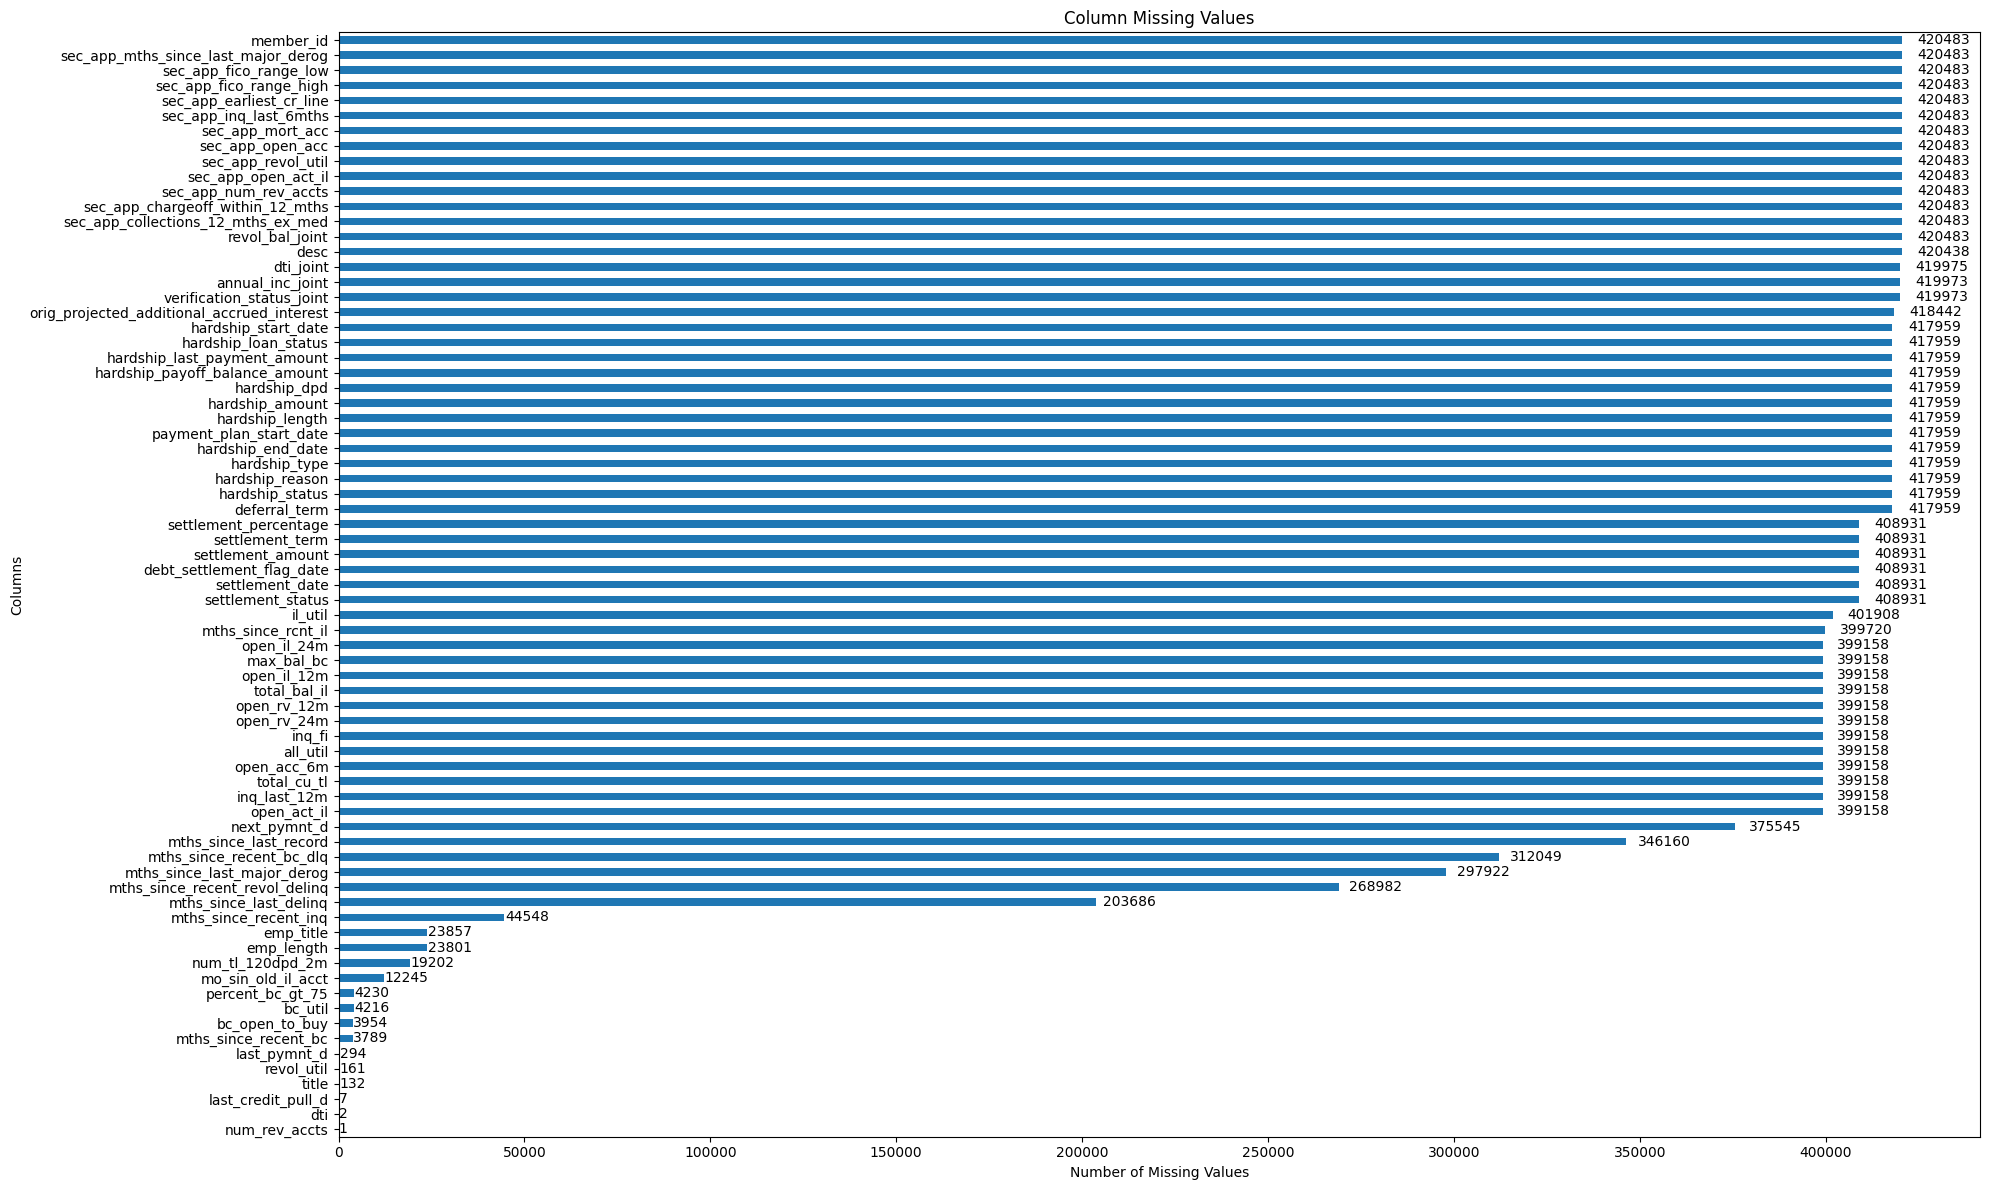

In [15]:
missing_counts_df1 = plot_missing_counts_by_columns(df1)

In [16]:
# 불필요한 특징 제거
df1 = df1.drop(['member_id', 'desc', 'url'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420483 entries, 0 to 421094
Columns: 153 entries, id to is_default
dtypes: float64(112), int64(1), object(40)
memory usage: 494.0+ MB


결측 비율 40% 초과 컬럼 정보 요약 (작업중)
___
1. 공동 대출 신청자 관련 컬럼 (4개)
    - 이 컬럼들은 대출 신청자가 한 명이 아닌 두 명 이상일 경우에만 데이터가 기록됩니다. 대부분의 대출이 단독 신청이므로 결측치가 매우 높습니다.
</br></br>
2. 2차 신청자 관련 컬럼 (12개)
    - 이 컬럼들은 sec_app_ 접두사가 붙으며, 공동 대출 신청의 2차 신청자에 대한 금융 정보를 담고 있습니다.
</br></br>
3. 채무 조정 및 부도 관련 컬럼 (20개)
- 이 컬럼들은 대출자가 재정적 어려움에 처했거나 채무 조정 프로그램을 이용했을 때만 데이터가 기록됩니다.

In [17]:
# 결측 비율 40% 초과 컬럼 정보
print(missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40])
missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40].shape

                                            Missing_Count  Missing_Ratio
mths_since_last_delinq                             203686      48.440960
mths_since_recent_revol_delinq                     268982      63.969768
mths_since_last_major_derog                        297922      70.852329
mths_since_recent_bc_dlq                           312049      74.212037
mths_since_last_record                             346160      82.324375
next_pymnt_d                                       375545      89.312767
open_act_il                                        399158      94.928451
inq_last_12m                                       399158      94.928451
total_cu_tl                                        399158      94.928451
open_acc_6m                                        399158      94.928451
all_util                                           399158      94.928451
inq_fi                                             399158      94.928451
open_rv_24m                                        

(58, 2)

1. 공동 대출 신청자 관련 컬럼 (4개)   
- annual_inc_joint: 공동 신청 시 연간 소득
- dti_joint: 공동 신청 시 부채-소득 비율
- verification_status_joint: 공동 신청 시 소득 확인 상태
- revol_bal_joint: 공동 신청 시 회전식 신용 잔고

In [ ]:
# 1.공동 대출 신청자 관련 컬럼들
joint_related_columns = [col for col in missing_counts_df1.index if 'joint' in col]
display(missing_counts_df1.loc[joint_related_columns])

df1 = df1.drop(joint_related_columns, axis=1)

2. 2차 신청자 관련 컬럼 (12개)

- sec_app_collections_12_mths_ex_med: 2차 신청자의 12개월 내 의료 제외 채권 추심 기록
- sec_app_chargeoff_within_12_mths: 2차 신청자의 12개월 내 부도 처리 기록
- sec_app_num_rev_accts: 2차 신청자의 신용 계좌 수
- sec_app_open_act_il: 2차 신청자의 할부 계좌 수
- sec_app_open_acc: 2차 신청자의 개설된 총 계좌 수
- sec_app_inq_last_6mths: 2차 신청자의 최근 6개월 내 신용 조회 수
- sec_app_mort_acc: 2차 신청자의 모기지 계좌 수
- sec_app_fico_range_high / low: 2차 신청자의 FICO 신용 점수
- sec_app_earliest_cr_line: 2차 신청자의 가장 오래된 신용 거래 기록
- sec_app_revol_util: 2차 신청자의 신용 한도 사용률
- sec_app_mths_since_last_major_derog: 2차 신청자의 마지막 주요 채무 불이행 후 경과 개월 수

In [ ]:
# 2. 2차 신청자 관련 컬럼들
sec_app_related_columns = [col for col in missing_counts_df1.index if 'sec_app' in col]
display(missing_counts_df1.loc[sec_app_related_columns])

df1 = df1.drop(sec_app_related_columns, axis=1)

3. 채무 조정 및 부도 관련 컬럼

- settlement_amount: 채무 조정 금액
- settlement_status: 채무 조정 상태
- settlement_date: 채무 조정일
- debt_settlement_flag_date: 채무 조정 플래그 설정일
- settlement_term: 채무 조정 기간
- settlement_percentage: 채무 조정된 금액의 비율
- hardship_status: 재정적 어려움 상태
- hardship_reason: 재정적 어려움 사유
- deferral_term: 상환 유예 기간
- hardship_amount: 재정적 어려움 지원 금액
- hardship_start_date / end_date: 재정적 어려움 시작/종료일
- hardship_type: 재정적 어려움 유형
- hardship_length: 재정적 어려움 기간
- hardship_last_payment_amount: 재정적 어려움 프로그램 내 마지막 상환액
- hardship_payoff_balance_amount: 재정적 어려움 프로그램 내 완납 잔액
- hardship_loan_status: 재정적 어려움 프로그램 내 대출 상태
- payment_plan_start_date: 상환 계획 시작일
- hardship_dpd: 재정적 어려움 프로그램 내 연체일 수
- orig_projected_additional_accrued_interest: 재정적 어려움 프로그램으로 인해 발생한 추가 이자

In [ ]:
# 3. 채무 조정 및 부도 관련 컬럼
settlement_related_columns = [col for col in missing_counts_df1.index if col in ['settlement', 'hardship']]
hardship_related_columns = [col for col in missing_counts_df1.index if 'hardship' in col]

display(missing_counts_df1.loc[settlement_related_columns + hardship_related_columns])

#df1 = df1.drop(settlement_related_columns + hardship_related_columns, axis=1)

In [ ]:
df1.info()